# 单发多框检测SSD（少点代码版）

这里我们来使用单发多框检测SSD来进行目标检测。

<center><img src="image/SSD.png" width=600></center>

## 导入库

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from utils.bbox import *
from utils.data import *
from utils.device import try_gpu

## 定义模型

#### 定义输出函数

In [2]:
from utils.SSD import cls_predictor, bbox_predictor

In [3]:
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

#### 展平连接预测输出

In [4]:
from utils.SSD import concat_preds

In [5]:
concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

### 下采样块

In [6]:
from utils.SSD import down_sample_blk

In [7]:
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

### 基础网络块

In [8]:
from utils.SSD import base_net

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

### 构建块

In [9]:
from utils.SSD import get_blk, blk_forward

In [10]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5

### TinySSD

In [11]:
from utils.SSD import TinySSD

In [12]:
net = TinySSD(num_classes=1, sizes=sizes, ratios=ratios)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


## 训练模型

### 加载数据集和初始化

In [13]:
batch_size = 32
train_iter, _ = load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


In [19]:
train_iter.dataset[0][0].shape

torch.Size([3, 256, 256])

In [16]:
device, net = try_gpu(), TinySSD(num_classes=1,sizes=sizes, ratios=ratios)
optimizer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

### 定义损失函数和评价函数

In [17]:
from utils.SSD import calc_loss, cls_eval, bbox_eval

### 开始训练

KeyboardInterrupt: 

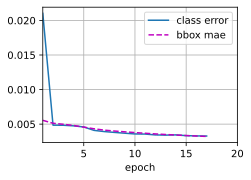

In [22]:
from utils.show import Animator
from utils.tools import Timer, Accumulator
num_epochs, timer = 20, Timer()
animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    # 训练精确度的和，训练精确度的和中的示例数
    # 绝对误差的和，绝对误差的和中的示例数
    metric = Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        optimizer.zero_grad()
        X, Y = features.to(device), target.to(device)

        # 生成多尺度的锚框，为每个锚框预测类别和偏移量
        anchors, cls_preds, bbox_preds = net(X)

        # 为每个锚框标注类别和偏移量
        bbox_labels, bbox_masks, cls_labels = multibox_target(anchors, Y)
        
        # 根据类别和偏移量的预测和标注值计算损失函数
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        
        l.mean().backward() # 这里是默认对第一个维度做平均，即对batchsize做平均

        optimizer.step()
        metric.add(
            cls_eval(cls_preds, cls_labels), 
            cls_labels.numel(),
            bbox_eval(bbox_preds, bbox_labels, bbox_masks),
            bbox_labels.numel()
        )
        
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]

    animator.add(epoch + 1, (cls_err, bbox_mae))

print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')

### 预测目标

我们将对下面图片进行预测🍌的位置

![banana](image/test.jpg)

In [23]:
X = torchvision.io.read_image('./image/test.jpg').unsqueeze(0).float()
X.shape

torch.Size([1, 3, 256, 256])

In [24]:
# 将X的宽高缩放到256
img = torchvision.transforms.Resize((256, 256))(X)
img.shape

torch.Size([1, 3, 256, 256])

TypeError: Invalid shape (256, 3, 256) for image data

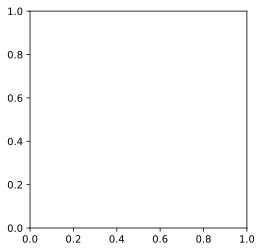

In [29]:
import numpy as np
# 显示img
plt.imshow(img.squeeze(0).permute(1, 2, 0).numpy().astype(np.uint8))
plt.show()

In [26]:
img = img.squeeze(0).permute(1, 2, 0).long()
img.shape

torch.Size([256, 256, 3])

In [27]:
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1) # 利用softmax转换成概率
    output = multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

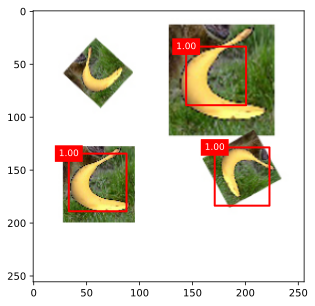

In [28]:
def display(img, output, threshold):
    plt.figure(figsize=(5, 5))
    fig = plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        show_bboxes(fig.axes, bbox, '%.2f' % score, 'r')

display(img, output.cpu(), threshold=0.9)